# Introduction

Text is one of the most widespread forms of sequence data. It can be understood as either a sequence of charactors or a sequence of words, but it's most common to work at level of words. Text-sequence processing includes following applications:

**Applications of deep learning for text data:**
1. Document classification
2. Articles lebelling
3. Sentiment analysis
4. Author identification
5. Question-answering
6. Language detection
7. Translation Tasks

- In true sense `deep learning models map the statistical structure of written language,` which is sufficient to solve many simple textual tasks and problems.
- Deep learning for natural-language processing is `pattern recognition applied to words, sequence, and paragraphs,` in much similar way that computer vision is pattern recognition applied to pixels.
- Deep-learning models don't take input as text like other models they only work with numeric tensors

**Three techniques to vectorize the text data:**
1. Segment text into words, and convert word into a vector
2. Segment text into charactors, and transform each chractors into a vector.
3. Extract n-grams of words, and transform each n-grams into a vector.

- There are many ways one can convert text to vector and it depends on what models one is using along with time or resources utilization.

**Typical workflow to prepare text data for machine learning models:**
1. Tokenization
2. One-Hot encoding or word indexing
3. Pad sequencing
4. Embedding layer (Word2Vec)
5. Corresponding word vector

- In this notebook, we are going to explore and solve news classification problem to classify 41 types of news headlines and news descriptions.

**Use-case:** Such text classification models are used in `News Apps` or by reporter to classify news topics for better reach to right audience.

**Problem-statement:** Build `news classification model` using deep learning teechniques and deploy model for reporters to classify and label news articles.

*Reference: Deep learning with python by Francois Chollet*

# Table of contents:

0. [Importing libraries](#lib)
1. [Data exploration and pre-processing](#eda)

  - [Profiling report of dataset](#pp)
  - [Text data visualization](#td)
  - [Text data pre-processing](#tdp)
  
  
2. [Tokenization and vectorization](#tv)
3. [What are the word embeddings?](#we)
4. [Model training using EmbeddingLayer,RNNs and LSTMs](#rnn)

  - [Baseline model 1](#base)
  - [What are the RNNs?](#rnets)
  - [Model training using LSTM](#model2)
  - [Loss and accuracy curve](#loss)
  
  
5. [Conclusion](#conclude)

# 0. Importing libraries

<a id="lib"></a>


In [ ]:
!pip install pydantic==1.10


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.4/138.4 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 22.9 MB/s eta 0:00:00
  Attempting uninstall: pydantic
    Found existing installation: pydantic 2.9.1
    Uninstalling pydantic-2.9.1:
      Successfully uninstalled pydantic-2.9.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 1.4.14 requires pydantic>=2.7.0, but you have pydantic 1.10.0 which is incompatible.
ydata-profiling 4.10.0 requires pydantic>=2, but you have pydantic 1.10.0 which is incompatible.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import nltk
# import pandas_profiling as pp
from markupsafe import escape
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ModelCheckpoint
# from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer

from sklearn.model_selection import train_test_split, cross_val_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

# model building imports
from keras.layers import Embedding, Flatten, Dense, Dropout
from keras.layers import Conv1D, SimpleRNN, Bidirectional, MaxPooling1D, GlobalMaxPool1D, LSTM, GRU
from keras.models import Sequential
from keras.regularizers import L1L2

%matplotlib inline

# matplotlib defaults
plt.style.use("ggplot")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

import warnings
warnings.filterwarnings('ignore')
nltk.download('omw-1.4')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# 1. Data exploration and pre-processing

<a id="eda"></a>


In [ ]:
!unzip News_Category_Dataset_v3.json.zip -d .

Archive:  News_Category_Dataset_v3.json.zip
  inflating: ./News_Category_Dataset_v3.json  


In [ ]:
df = pd.read_json('News_Category_Dataset_v3.json', lines=True)
df.head()

link  \
0  https://www.huffpost.com/entry/covid-boosters-...   
1  https://www.huffpost.com/entry/american-airlin...   
2  https://www.huffpost.com/entry/funniest-tweets...   
3  https://www.huffpost.com/entry/funniest-parent...   
4  https://www.huffpost.com/entry/amy-cooper-lose...   

                                            headline   category  \
0  Over 4 Million Americans Roll Up Sleeves For O...  U.S. NEWS   
1  American Airlines Flyer Charged, Banned For Li...  U.S. NEWS   
2  23 Of The Funniest Tweets About Cats And Dogs ...     COMEDY   
3  The Funniest Tweets From Parents This Week (Se...  PARENTING   
4  Woman Who Called Cops On Black Bird-Watcher Lo...  U.S. NEWS   

                                   short_description               authors  \
0  Health experts said it is too early to predict...  Carla K. Johnson, AP   
1  He was subdued by passengers and crew when he ...        Mary Papenfuss   
2  "Until you have a dog you don't understand wha...         Elyse Wanshel   
3  "Accidentally put grown-up toothpaste on my to...      Caroline Bologna   
4  Amy Cooper accused investment firm Franklin Te...        Nina Golgowski   

        date  
0 2022-09-23  
1 2022-09-23  
2 2022-09-23  
3 2022-09-23  
4 2022-09-22

In [ ]:
# shape of the dataset
print(df.shape)
# total number of unique categories
print("Unique categories:",df['category'].nunique())
print("-------------------------------------------------")
# information about metadata
df.info()

(209527, 6)
Unique categories: 42
-------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209527 entries, 0 to 209526
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   link               209527 non-null  object        
 1   headline           209527 non-null  object        
 2   category           209527 non-null  object        
 3   short_description  209527 non-null  object        
 4   authors            209527 non-null  object        
 5   date               209527 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.6+ MB


In [ ]:
# general descrption of dataset
df.describe().style.set_properties(**{'background-color': '#F0F0F0',
                                    'color': '#222222',
                                    'border': '1.5px  solid black'})

## 1.1 Profiling report of dataset

<a id="pp"></a>


In [ ]:
!pip install pydantic==1.10.2
!pip install --upgrade ydata-profiling pydantic


  Using cached pydantic-2.9.1-py3-none-any.whl.metadata (146 kB)
Using cached pydantic-2.9.1-py3-none-any.whl (434 kB)
  Attempting uninstall: pydantic
    Found existing installation: pydantic 1.10.2
    Uninstalling pydantic-1.10.2:
      Successfully uninstalled pydantic-1.10.2


In [ ]:
# produce pandas profiling report
# df.profile_report()
import pandas as pd
from ydata_profiling import ProfileReport
profile_report = ProfileReport(df)
profile_report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

ValueError: Couldn't find space to draw. Either the Canvas size is too small or too much of the image is masked out.

<Figure size 600x400 with 0 Axes>

**Key findings:**

1. Dataset has total **41** distinct categories of news articles
2. **'Politics'** is the most common category of news in our dataset.
3. We have total of **27993** unique authors who have written various news articles
4. Maximum length of headline is **320** while median length is around **59.**
5. Maximum length of description is **1472** while median length is around **120.**

## 1.2 Text data visualization

<a id="td"></a>


In [ ]:
# drop columns like authors, links and date as they are irrelevent to our problem.
new_df = df.drop(columns=['authors','link','date'])
new_df.head()

headline   category  \
0  Over 4 Million Americans Roll Up Sleeves For O...  U.S. NEWS   
1  American Airlines Flyer Charged, Banned For Li...  U.S. NEWS   
2  23 Of The Funniest Tweets About Cats And Dogs ...     COMEDY   
3  The Funniest Tweets From Parents This Week (Se...  PARENTING   
4  Woman Who Called Cops On Black Bird-Watcher Lo...  U.S. NEWS   

                                   short_description  
0  Health experts said it is too early to predict...  
1  He was subdued by passengers and crew when he ...  
2  "Until you have a dog you don't understand wha...  
3  "Accidentally put grown-up toothpaste on my to...  
4  Amy Cooper accused investment firm Franklin Te...

### 1.2.1 TOP 10 Categories of News Articles

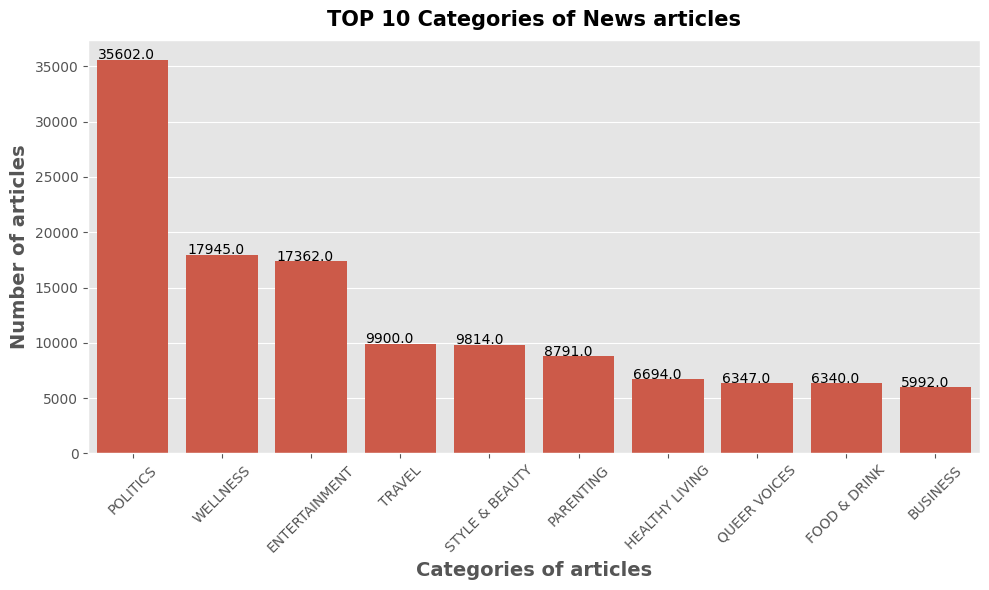

In [ ]:
# # Top categories by and number of articles per categories
# cat_df = pd.DataFrame(new_df['category'].value_counts()).reset_index()
# cat_df.rename(columns={'index':'news_classes','category':'numcat'}, inplace=True)

# # Visualize top 10 categories and proportion of each categories in dataset
# plt.figure(figsize=(10,6))
# ax = sns.barplot(np.array(cat_df.news_classes)[:10], np.array(cat_df.numcat)[:10])
# for p in ax.patches:
#     ax.annotate(p.get_height(), (p.get_x()+0.01, p.get_height() + 50))
# plt.title("TOP 10 Categories of News articles", size=15)
# plt.xlabel("Categories of articles", size=14)
# plt.xticks(rotation=45)
# plt.ylabel("Number of articles", size=14)
# plt.show()


##Udpated code for V3 dataset

# Create DataFrame of top categories and their counts
cat_df = pd.DataFrame({
    'news_classes': new_df['category'].value_counts().index,  # The categories
    'numcat': new_df['category'].value_counts().values        # The counts
})

# Visualize top 10 categories and proportion of each category in the dataset
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=np.array(cat_df.news_classes)[:10], y=np.array(cat_df.numcat)[:10])
for p in ax.patches:
    ax.annotate(p.get_height(), (p.get_x() + 0.01, p.get_height() + 50))

plt.title("TOP 10 Categories of News articles", size=15)
plt.xlabel("Categories of articles", size=14)
plt.xticks(rotation=45)
plt.ylabel("Number of articles", size=14)
plt.show()


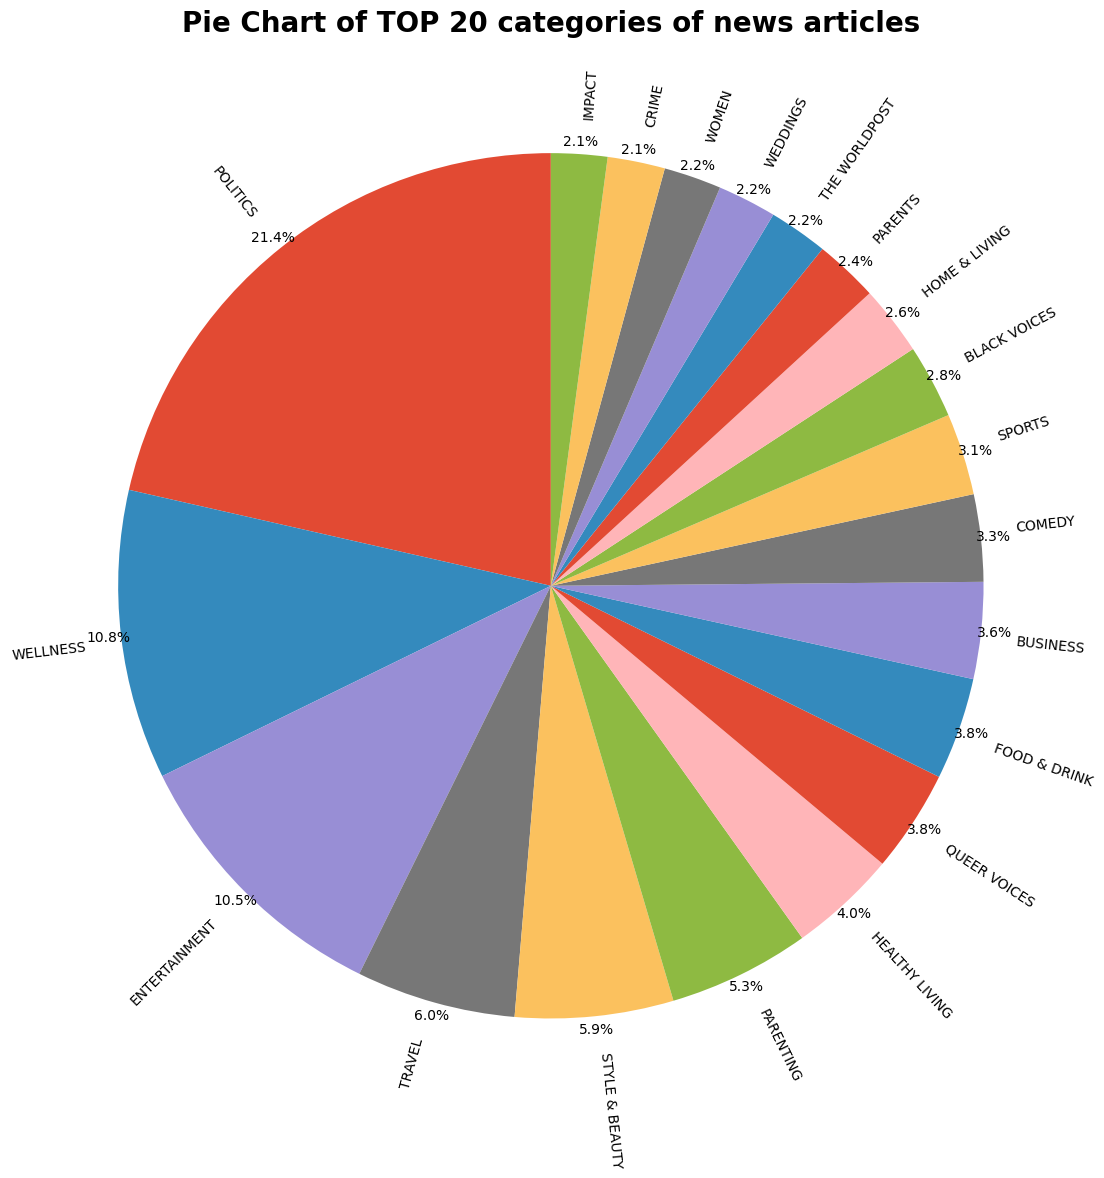

In [ ]:
# plot the pie chart of top 20 categories of news articles
fig = plt.figure(figsize=(12,12))
A = plt.pie(cat_df['numcat'][:20],
            labels=cat_df['news_classes'][:20],
            autopct='%1.1f%%',
            startangle=90,
            labeldistance=1.08,
            pctdistance=1.03,
            rotatelabels=45
            )

plt.title("Pie Chart of TOP 20 categories of news articles", size=20, weight='bold')
plt.show()

### 1.2.2 Lengths of 'headline' and 'short_description' of each category

In [ ]:
# create final dataframe of combined headline and short_description
final_df = new_df.copy()
final_df['length_of_news'] = final_df['headline'] + final_df['short_description']
final_df.drop(['headline','short_description'], inplace=True, axis=1)
final_df['len_news'] = final_df['length_of_news'].map(lambda x: len(x))
final_df.head()

category                                     length_of_news  len_news
0  U.S. NEWS  Over 4 Million Americans Roll Up Sleeves For O...       230
1  U.S. NEWS  American Airlines Flyer Charged, Banned For Li...       248
2     COMEDY  23 Of The Funniest Tweets About Cats And Dogs ...       133
3  PARENTING  The Funniest Tweets From Parents This Week (Se...       215
4  U.S. NEWS  Woman Who Called Cops On Black Bird-Watcher Lo...       233

In [ ]:
# maximum length of news in each category
lenmax_df = final_df.groupby('category')['len_news'].max().reset_index().sort_values(by='len_news',ascending=False)
lenmax_df.head()

category  len_news
24        POLITICS      1486
41       WORLDPOST      1424
4          COLLEGE      1225
16  HEALTHY LIVING      1073
38        WELLNESS      1036

In [ ]:
# minimum lenght of news in each category
lenmin_df = final_df.groupby('category')['len_news'].min().reset_index().sort_values(by='len_news',ascending=False)
lenmin_df.head()

category  len_news
35      U.S. NEWS        73
8         DIVORCE        66
33  THE WORLDPOST        56
36       WEDDINGS        54
21          MONEY        51

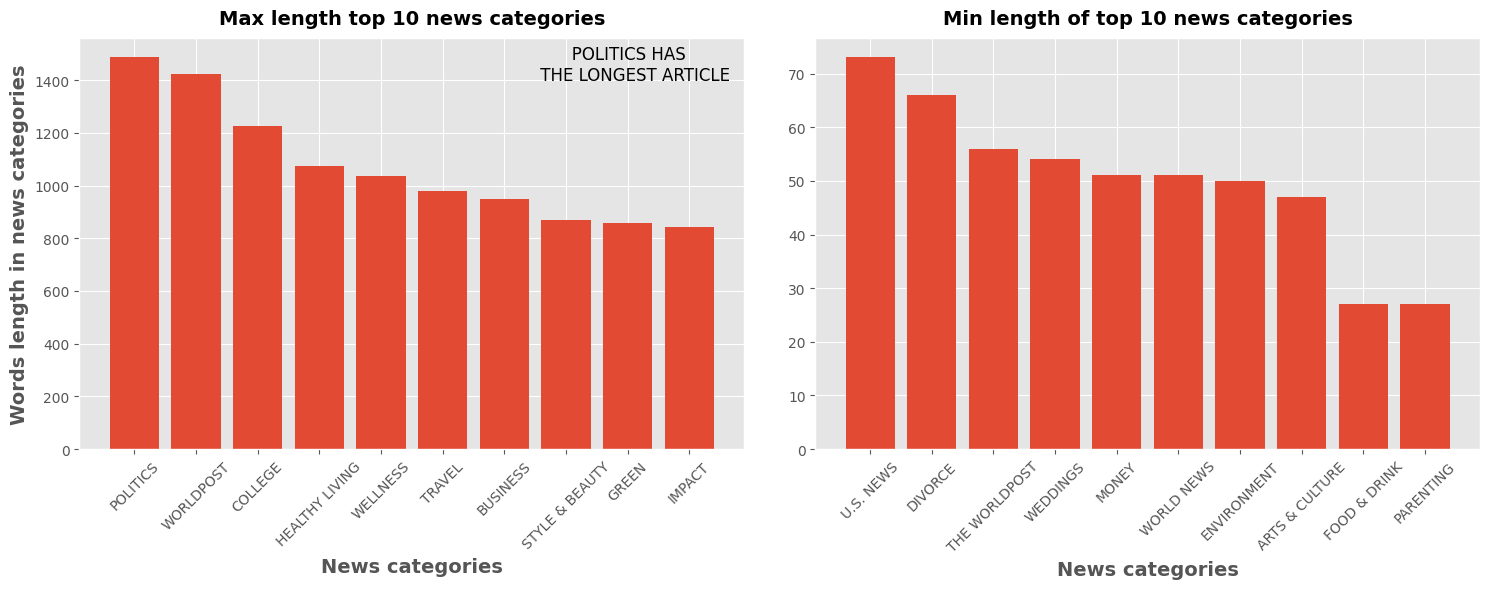

In [ ]:
# plot the bar plots of max and min length of news articles
plt.figure(figsize=(15,6))

plt.subplot(121)
plt.bar(lenmax_df['category'][:10],lenmax_df['len_news'][:10])
plt.xticks(rotation=45)
plt.ylabel("Words length in news categories", size=14)
plt.xlabel("News categories",  size=14)
plt.text(6.5,1400, '''       POLITICS HAS
 THE LONGEST ARTICLE''', fontsize=12)
plt.title("Max length top 10 news categories", size=14)

plt.subplot(122)
plt.bar(lenmin_df['category'][:10], lenmin_df['len_news'][:10])
plt.xticks(rotation=45)
plt.xlabel("News categories", size=14)
plt.title("Min length of top 10 news categories", size=14)

plt.show()

**Key findings:**

1. From all the categories of news **POLITICS** has the **most number of articles** as well as **length of characters** in the article (headlines and short-description)
2. After 'POLITICS' category, 'WORLDPOST', 'COLLEGE', 'HEALTHY LIVING','WELLNESS' categories are in top 5 most length of articles
3. 'POLITICS', 'WELLNESS' and 'ENTERTAINTMENT' are top 3 categories having most number of articles in out dataset.

### 1.2.3 Wordclouds of categories and news articles

- Wordcloud of categories in out dataframe
- Wordcloud of new articles in each of the categories

(-0.5, 1599.5, 599.5, -0.5)

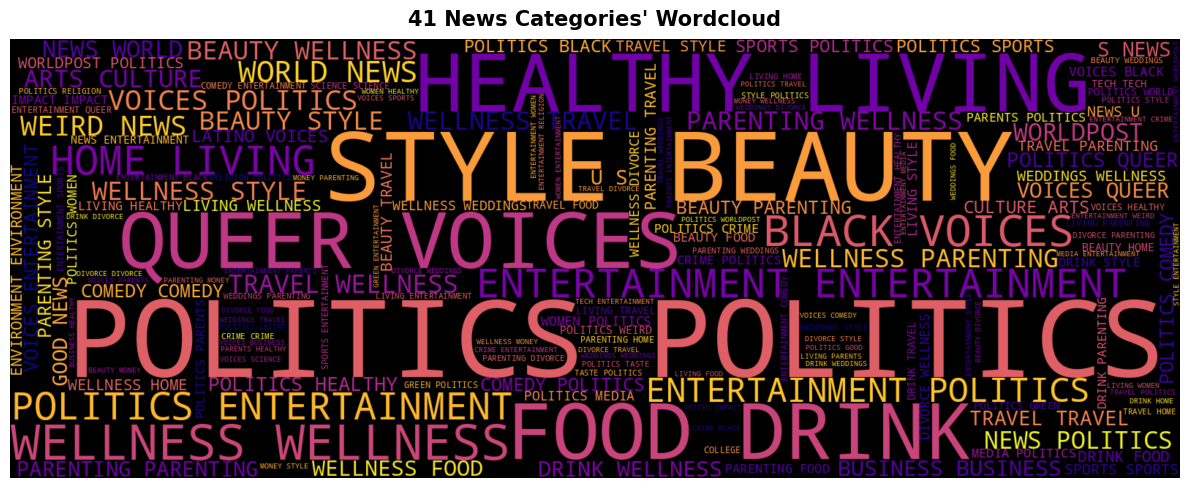

In [ ]:
# wordcloud of categories of news articles in our dataset
plt.figure(figsize=(12,12))
wc = WordCloud(max_words=1000,
               min_font_size=10,
               height=600,
               width=1600,
               background_color='black',
               contour_color='black',
               colormap='plasma',
               repeat=False,
               stopwords=STOPWORDS).generate(' '.join(final_df.category))

plt.title("41 News Categories' Wordcloud", size=15, weight='bold')
plt.imshow(wc, interpolation= "bilinear")
plt.axis('off')

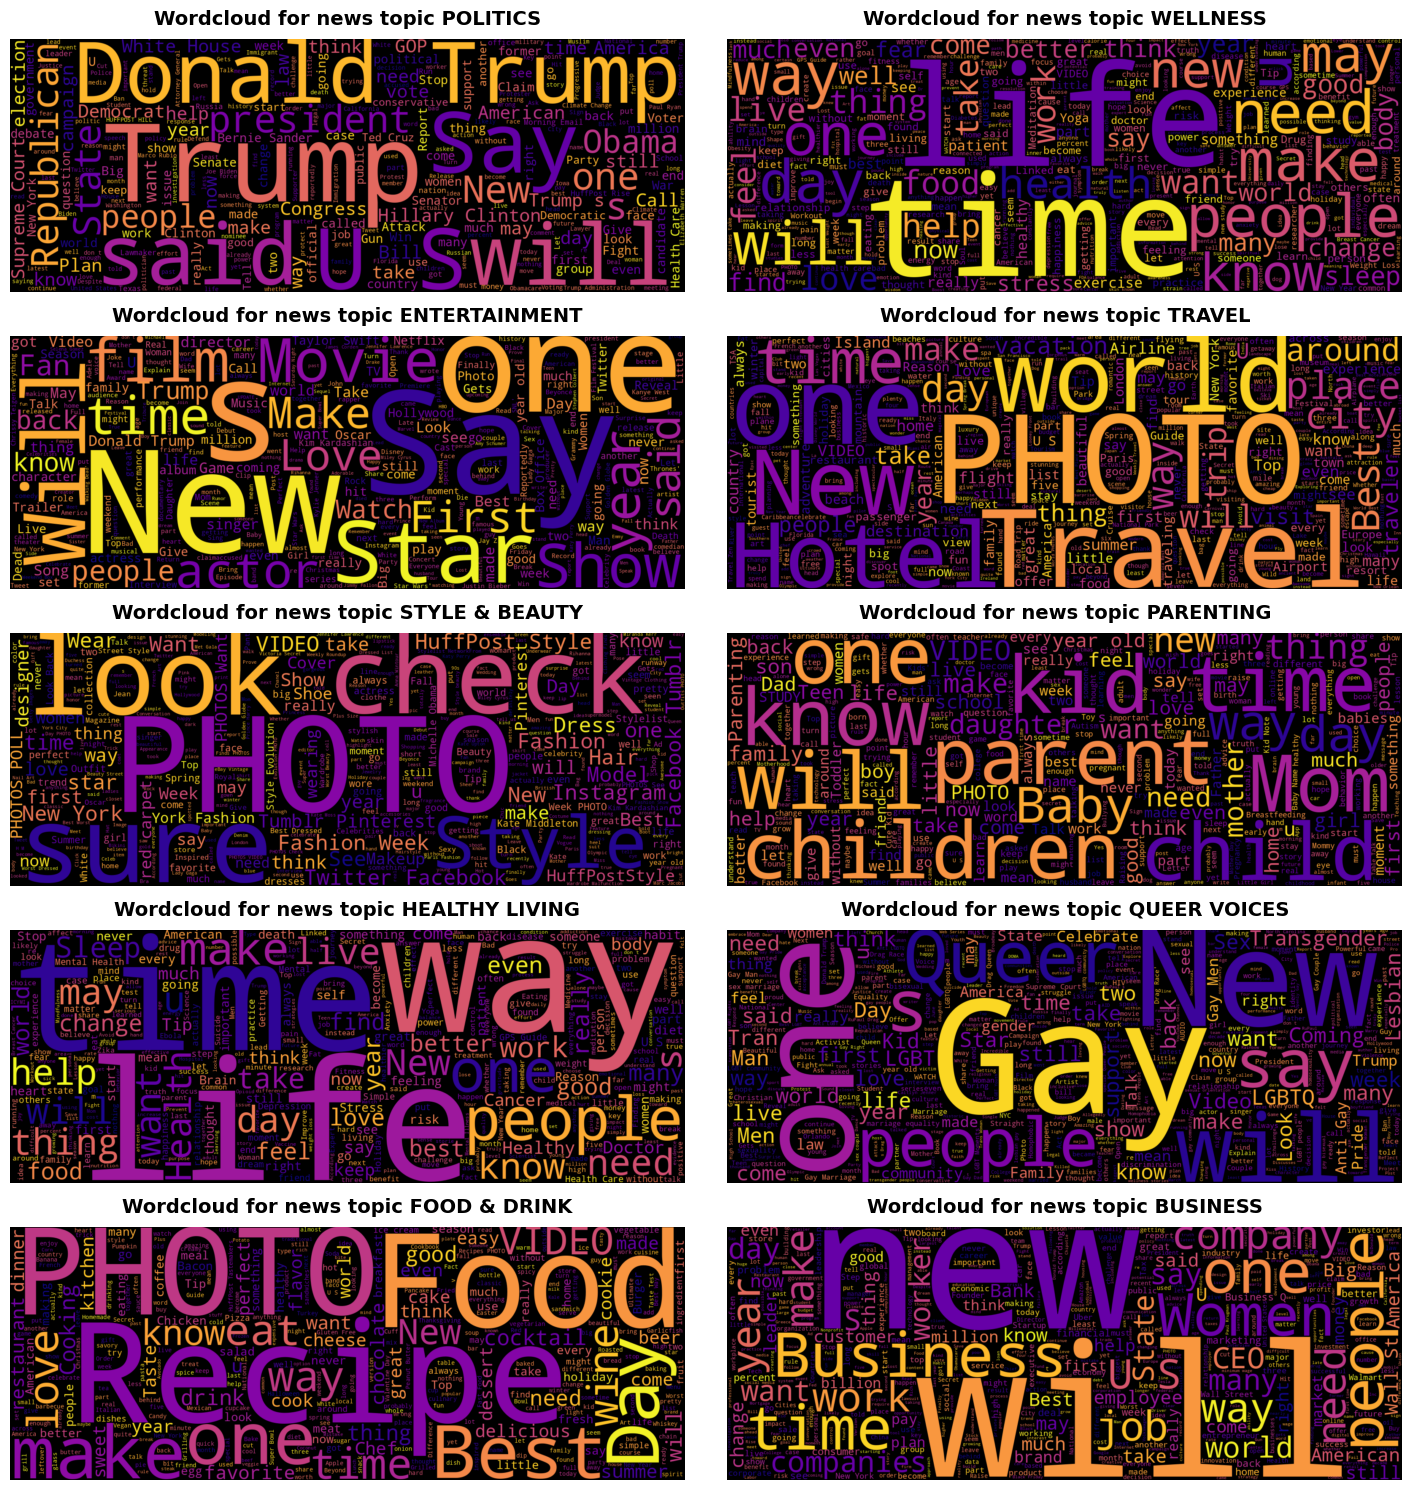

In [ ]:
# create new dataframe of category and length of each news articles in that categories
ndf = final_df.copy()
ndf.drop('len_news', inplace=True, axis=1)

# list of top 10  categories in out dataset
categories = cat_df['news_classes'][:10].to_list()

# list of news articles of each top 10 categories list
articles_list = []

for i in categories:
    cat_ndf = ndf[ndf['category'] == i]
    cat_array = cat_ndf['length_of_news'].values  # array of news articles text in each category
    articles_list.append(cat_array)

# create a wordcloud instance
wc1 = WordCloud(max_words=1000,
               min_font_size=10,
               height=600,
               width=1600,
               background_color='black',
               contour_color='black',
               colormap='plasma',
               repeat=True,
               stopwords=STOPWORDS)

# plot the figure of 10 wordcloud from out dataset
plt.figure(figsize=(15,15))

for idx, j in enumerate(categories):
    plt.subplot(5,2,idx+1)
    cloud = wc1.generate(' '.join(articles_list[idx]))
    plt.imshow(cloud, interpolation= "bilinear")
    plt.title(f"Wordcloud for news topic {j}")
    plt.axis('off')

## 1.3 Text-data Preprocessing

<a id="tdp"></a>


In [ ]:
# start with removing some data from politics dataframe ndf
politics_list = list(ndf[ndf['category'] == 'POLITICS'].index)
list_16 = politics_list[:16000] # list of 16000 row labels of POLITICS category

# drop these 16000 labels from the dataset
ndf2 = ndf.copy()
ndf2.drop(list_16, axis=0, inplace=True)

NameError: name 'ndf' is not defined

In [ ]:
# clean the text data using regex and data cleaning function
def datacleaning(text):
    whitespace = re.compile(r"\s+")
    user = re.compile(r"(?i)@[a-z0-9_]+")
    text = whitespace.sub(' ', text)
    text = user.sub('', text)
    text = re.sub(r"\[[^()]*\]","", text)
    text = re.sub("\d+", "", text)
    text = re.sub(r'[^\w\s]','',text)
    text = re.sub(r"(?:@\S*|#\S*|http(?=.*://)\S*)", "", text)
    text = text.lower()

    # removing stop-words
    text = [word for word in text.split() if word not in list(STOPWORDS)]

    # word lemmatization
    sentence = []
    for word in text:
        lemmatizer = WordNetLemmatizer()
        sentence.append(lemmatizer.lemmatize(word,'v'))

    return ' '.join(sentence)

In [ ]:
# Udates related to version 3
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# Example of pre-processing using above function
print("Text sentence before pre-processing:\n",ndf2['length_of_news'][0])
print("---"*35)
print("Text sentence after pre-processing:\n",datacleaning(ndf2['length_of_news'][0]))

NameError: name 'ndf2' is not defined

In [ ]:
# apply datacleaning function to column 'length_of_news'
ndf2['length_of_news'] = ndf2['length_of_news'].apply(datacleaning)

NameError: name 'ndf2' is not defined

In [ ]:
# length of total characters before and after cleaning text data
old_length = ndf['length_of_news'].apply(len).sum()
new_length = ndf2['length_of_news'].apply(len).sum()
print(f"Old chracters length of text data: {old_length}")
print(f"New chracters length of text data: {new_length}")

Old chracters length of text data: 36169394
New chracters length of text data: 23045855


In [ ]:
# length of total words before and after cleaning text data
old_text = ndf['length_of_news'].apply(lambda x: len([i for i in x.split()])).sum()
new_text = ndf2['length_of_news'].apply(lambda x: len([i for i in x.split()])).sum()
print(f"Old word length of text data: {old_text}")
print(f"New word length of text data: {new_text}")

Old word length of text data: 5942993
New word length of text data: 3290751


# 2. Tokenization and vectorization

<a id="tv"></a>


### Some of the most common NLP terminologies

**1. Document**
- Each and every training example used in text dataset known as a Document.

**2. Corpus**
- Collections of documents called as a corpus of text data

**3. Vocabulary(BoW)**
- Vocabulary or Bag-of-words is nothing but number of unique words are present in text corpus.

**4. Stop words**
- Stop words are those used most commonly in any language, e.g. 'the', 'a', etc. they do not form any meaning to the context of the text

**5. N-grams**
- N-grams is text representation in form of N words sequences to extract meaning and context out of each sentences or paragraphs.

**6. Tokenization**
- It's an early step in NLP process to split text sentences into smaller words or tokens.

**7. Vectorization**
- Machine do not understand text or words, so text data or tokens must be converted to corrospinding word index or word vectors in order process text and build models. process of converting tokenized words into numerical vectors called as a vectorization.

### One-hot encoding and word-indexing example on chunk of data

In [ ]:
# tokenization and vectorization workflow
# word level one-hot encoding for sample data

samples = list(ndf2['length_of_news'][:5].values)  # samples of first 5 documents of out dataset

token_index = {}  # builds an index of tokens in the data
for sample in samples:
    for word in sample.split():
        if word not in token_index:
            token_index[word] = len(token_index) + 1 # assigning unique index to each unique words

max_length = 15

results = np.zeros(shape=(len(samples),   # results will be stored in this array
                          max_length,
                          max(token_index.values()) +1))

print("Shape of stored results array:", results.shape)
print("Token index of unique words: \n", token_index)

for i, sample in enumerate(samples):
    for j, word in list(enumerate(sample.split()))[:max_length]:
        index = token_index.get(word)
        results[i,j,index] = 1

Shape of stored results array: (5, 15, 91)
Token index of unique words: 
 {'million': 1, 'americans': 2, 'roll': 3, 'sleeves': 4, 'omicrontargeted': 5, 'covid': 6, 'boostershealth': 7, 'experts': 8, 'say': 9, 'early': 10, 'predict': 11, 'whether': 12, 'demand': 13, 'match': 14, 'dose': 15, 'new': 16, 'boosters': 17, 'us': 18, 'order': 19, 'fall': 20, 'american': 21, 'airlines': 22, 'flyer': 23, 'charge': 24, 'ban': 25, 'life': 26, 'punch': 27, 'flight': 28, 'attendant': 29, 'videohe': 30, 'subdue': 31, 'passengers': 32, 'crew': 33, 'flee': 34, 'back': 35, 'aircraft': 36, 'confrontation': 37, 'accord': 38, 'attorneys': 39, 'office': 40, 'los': 41, 'angeles': 42, 'funniest': 43, 'tweet': 44, 'cat': 45, 'dog': 46, 'week': 47, 'sept': 48, 'dont': 49, 'understand': 50, 'eat': 51, 'parent': 52, 'accidentally': 53, 'put': 54, 'grownup': 55, 'toothpaste': 56, 'toddlers': 57, 'toothbrush': 58, 'scream': 59, 'clean': 60, 'teeth': 61, 'carolina': 62, 'reaper': 63, 'dip': 64, 'tabasco': 65, 'sauce

### One-hot encoding and indexing of train and test data

In [ ]:
# one hot encoding using keras tokenizer and pad sequencing
X = ndf2['length_of_news']
encoder = LabelEncoder()
y = encoder.fit_transform(ndf2['category'])
print("shape of input data: ", X.shape)
print("shape of target variable: ", y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

tokenizer = Tokenizer(num_words=100000, oov_token='<00V>')
tokenizer.fit_on_texts(X_train) # build the word index
# padding X_train text input data
train_seq = tokenizer.texts_to_sequences(X_train) # converts strinfs into integer lists
train_padseq = pad_sequences(train_seq, maxlen=20) # pads the integer lists to 2D integer tensor

# padding X_test text input data
test_seq = tokenizer.texts_to_sequences(X_test)
test_padseq = pad_sequences(test_seq, maxlen=20)

word_index = tokenizer.word_index
max_words = 150000  # total number of words to consider in embedding layer
total_words = len(word_index)
maxlen = 130 # max length of sequence
y_train = to_categorical(y_train, num_classes=41)
y_test = to_categorical(y_test, num_classes=41)
print("Length of word index:", total_words)

shape of input data:  (193527,)
shape of target variable:  (193527,)


IndexError: index 41 is out of bounds for axis 1 with size 41

In [ ]:
# One hot encoding using keras tokenizer and pad sequencing
X = ndf2['length_of_news']
encoder = LabelEncoder()
y = encoder.fit_transform(ndf2['category'])

print("shape of input data: ", X.shape)
print("shape of target variable: ", y.shape)

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# Tokenizer
tokenizer = Tokenizer(num_words=100000, oov_token='<00V>')
tokenizer.fit_on_texts(X_train)  # Build the word index

# Padding X_train text input data
train_seq = tokenizer.texts_to_sequences(X_train)  # Converts strings into integer lists
train_padseq = pad_sequences(train_seq, maxlen=20)  # Pads the integer lists to 2D integer tensor

# Padding X_test text input data
test_seq = tokenizer.texts_to_sequences(X_test)
test_padseq = pad_sequences(test_seq, maxlen=20)

# Get the word index and max word count
word_index = tokenizer.word_index
total_words = len(word_index)
print("Length of word index:", total_words)

# Determine the correct number of classes
num_classes = len(np.unique(y_train))  # Automatically find the number of unique labels

# One-hot encoding the labels
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)


shape of input data:  (193527,)
shape of target variable:  (193527,)
Length of word index: 180892


# 3. What are the Wordembeddings?

<a id="we"></a>


> A word embedding is a learned representation for text where words that have the same meaning and save similar representation

Reference:- [Machinelearningmastery](https://machinelearningmastery.com/what-are-word-embeddings/)

- This approach to representing words and documents that may be considered one of the key breakthroughs of deep learning on chllengin NLP problems
- Word embeddings are alternative to one-hot encoding along with dimensionality reduction

> One-hot word vectors - Sparse, High-dimensional and Hard-coded

> Word embeddings - Dense, Lower-Dimensional and Learned from the data

- Keras library has embeddings layer which does word representation of given text corpus

**tf.keras.layers.Embedding(
    input_dim,
    output_dim,
    embeddings_initializer='uniform',
    embeddings_regularizer=None,
    activity_regularizer=None,
    embeddings_constraint=None,
    mask_zero=False,
    input_length=None,
    **kwargs
)**

**Key Arguments:**

1) input_dim - Size of vocabulary - length of word index

2) output_dim - Output dimention of word representation

3) input-length - max input sequence length of document

**Visual depiction of word embeddings:-**

![image.png](attachment:a3eee381-6949-47d3-b384-c42dff5e415b.png)

# 4. Model training using embedding layer and RNN (Baseline)

<a id="rnn"></a>


## 4.1 Baseline model 1 with SimpleRNN and embedding layer

<a id="base"></a>


In [ ]:
# basline model using embedding layers and simpleRNN
model = Sequential()
model.add(Embedding(total_words, 70, input_length=maxlen))
model.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model.add(Bidirectional(SimpleRNN(64, dropout=0.1, recurrent_dropout=0.30, activation='tanh', return_sequences=True)))
model.add(SimpleRNN(32, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(41, activation='softmax'))
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_2 (SimpleRNN)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## 4.2 What are the Recurrent Neural Networks??

<a id="rnets"></a>


- A major difference between densely connected neural network and recurrent nueral network, is that fully connected networks have no memory in units of each layer. while `recurrent nueral networks do store state of previous timestep or sequence` while assigning weights  to current input.

- In RNNs, we `process inputs word by word or eye saccade but eye saccade` - while keeping memories of what came before in each cells. this gives fluid representation of sequences and gives nueral network a ability to capture context of sequence rather than absolute representation of words.

> "Recurrent nueral network processes sequences by iterating through the sequence elements and maintaining a a `state` containing information relative to what it has seen so far. In effect, an RNN is a type of nueral network that has an internal loop."

-6.2 Understanding recurrent nueral network, Deep learning using python by chollat

- See the below depiction of how RNNs learns the context of sequences.

![image.png](attachment:25fc0e9b-bfe0-4f71-8e3c-6926763958fc.png)

- A visual dipiction of RNN cell with a loop and unrolled RNN cell.

![image.png](attachment:fbc32ab6-09f9-4c63-a2f3-2b171d935796.png)

In [ ]:
# udated code for version3

# Adjust the padding sequence to match the model's expected input shape
maxlen = 130  # Ensure this matches the model's input expectation

# padding X_train text input data
train_seq = tokenizer.texts_to_sequences(X_train)  # Converts strings into integer lists
train_padseq = pad_sequences(train_seq, maxlen=maxlen)  # Pads to the specified maxlen

# padding X_test text input data
test_seq = tokenizer.texts_to_sequences(X_test)
test_padseq = pad_sequences(test_seq, maxlen=maxlen)

# Ensure the model input shape is compatible
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=128, input_length=maxlen))  # Use maxlen here
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# SETUP A EARLY STOPPING CALLBACK and model checkpoint API
earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy',
                                              patience=5,
                                              verbose=1,
                                              mode='min'
                                             )
# checkpointer = ModelCheckpoint(filepath='bestvalue', monitor='val_loss', verbose=0, save_best_only=True)
checkpointer = ModelCheckpoint(filepath='bestvalue.keras', monitor='val_loss', verbose=0, save_best_only=True)

callback_list = [checkpointer, earlystopping]

# fit model to the data
history = model.fit(train_padseq, y_train,
                   batch_size=128,
                   epochs=1,
                   validation_split=0.2,
                   callbacks=callback_list
                   )

# evaluate the model
test_loss, test_acc = model.evaluate(test_padseq, y_test, verbose=0)
print("Test loss and accuracy:", test_loss, test_acc)


NameError: name 'max_words' is not defined

In [ ]:
# Older version
model.compile(optimizer='rmsprop',
            loss='categorical_crossentropy',
            metrics=['accuracy']
            )
# SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy',
                                             patience=5,
                                              verbose=1,
                                              mode='min'
                                             )
checkpointer = ModelCheckpoint(filepath='bestvalue',moniter='val_loss', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]

# fit model to the data
history = model.fit(train_padseq, y_train,
                   batch_size=128,
                    epochs=15,
                    validation_split=0.2
                   )

# evalute the model
test_loss, test_acc = model.evaluate(test_padseq, y_test, verbose=0)
print("test loss and accuracy:", test_loss, test_acc)

TypeError: ModelCheckpoint.__init__() got an unexpected keyword argument 'moniter'

**Notes:**

- Experiment 1:
Parameters: max_words=100000, output_dim=50, maxlen=50, epoch=10.
Model is highly overfitting as training accuracy comes around 84% while test accuracy is barely 40%.

- Experiment 2:
Params: max_words=150000, out_dim=50, maxlen=80, epoch=10, added droput layers in RNN
Model do not overfit but underfit and biased. val_acc comes again almost 39.3% while train accuracy is only 42%. model needs more parameters with more epochs

- Experiment 3:
Params: max_words=total_words, out_dim=70, maxlen=100, epoch=15, addding bidirection layer over both dropout RNN
an improvement in train accuracy to 63% and val_accuracy to 49% max at epoch 13. after epoch 13 model started overfitting. (next step) model can be more complex with regularization, model is forgetting information after 3rd RNN layer due to lower number of units, this needs to be solved.

In [ ]:
#model.save("news_clf_exp03.h5")

## 4.3 Model 2, training using Conv1D, Bi-directional RNN, LSTMs and GRU layer

<a id="model2"></a>


In [ ]:
model2 = Sequential()
model2.add(Embedding(total_words, 100, input_length=maxlen))
model2.add(Bidirectional(LSTM(64, dropout=0.1, recurrent_dropout=0.10, activation='tanh', return_sequences=True)))
model2.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model2.add(Bidirectional(SimpleRNN(64, dropout=0.2, recurrent_dropout=0.20, activation='tanh', return_sequences=True)))
model2.add(Conv1D(72, 3, activation='relu'))
model2.add(MaxPooling1D(2))
model2.add(SimpleRNN(64, activation='tanh', dropout=0.2, recurrent_dropout=0.20, return_sequences=True))
model2.add(GRU(64, recurrent_dropout=0.20, recurrent_regularizer='l1_l2'))
model2.add(Dropout(0.2))
model2.add(Dense(41, activation='softmax'))
model2.summary()

NameError: name 'maxlen' is not defined

In [ ]:
model2.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy']
              )
# SETUP A EARLY STOPPING CALL and model check point API
earlystopping = keras.callbacks.EarlyStopping(monitor='accuracy',
                                              patience=5,
                                              verbose=1,
                                              mode='min'
                                              )
checkpointer = ModelCheckpoint(filepath='bestvalue1',moniter='val_loss', verbose=0, save_best_only=True)
callback_list = [checkpointer, earlystopping]

# fit model to the data
history2 = model2.fit(train_padseq, y_train,
                     batch_size=128,
                     epochs=15,
                     validation_split=0.2,
                     shuffle=True
                    )

# evalute the model
test_loss2, test_acc2 = model2.evaluate(test_padseq, y_test, verbose=0)
print("test loss and accuracy:", test_loss2, test_acc2)

Epoch 1/15
925/925 [==============================] - 738s 767ms/step - loss: 3.1143 - accuracy: 0.2826 - val_loss: 2.3098 - val_accuracy: 0.4169
Epoch 2/15
925/925 [==============================] - 701s 758ms/step - loss: 2.1037 - accuracy: 0.4657 - val_loss: 2.1172 - val_accuracy: 0.4563
Epoch 3/15
925/925 [==============================] - 680s 735ms/step - loss: 1.8343 - accuracy: 0.5302 - val_loss: 1.9591 - val_accuracy: 0.5035
Epoch 4/15
925/925 [==============================] - 685s 740ms/step - loss: 1.6523 - accuracy: 0.5757 - val_loss: 1.9184 - val_accuracy: 0.5191
Epoch 5/15
925/925 [==============================] - 676s 731ms/step - loss: 1.5084 - accuracy: 0.6136 - val_loss: 1.9594 - val_accuracy: 0.5208
Epoch 6/15
925/925 [==============================] - 686s 741ms/step - loss: 1.3833 - accuracy: 0.6454 - val_loss: 1.9956 - val_accuracy: 0.5117
Epoch 7/15
925/925 [==============================] - 667s 721ms/step - loss: 1.2668 - accuracy: 0.6784 - val_loss: 1.9952 -

In [ ]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Assuming you have 42 classes
num_classes = 42

# Ensure correct number of classes in to_categorical
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

# Define the model
model2 = Sequential([
    Embedding(input_dim=150000, output_dim=128, input_length=130),  # Adjust input_length as needed
    LSTM(128, return_sequences=False),  # Set return_sequences to False for the final LSTM layer
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')  # Correct output shape, ensure num_classes is 42
])

# Compile the model
model2.compile(optimizer='rmsprop',
               loss='categorical_crossentropy',
               metrics=['accuracy']
              )

# SETUP EARLY STOPPING CALLBACK AND MODEL CHECKPOINT API
earlystopping = EarlyStopping(monitor='val_accuracy',
                              patience=5,
                              verbose=1,
                              mode='max')  # Use 'max' for accuracy
# checkpointer = ModelCheckpoint(filepath='bestvalue1',
#                                monitor='val_loss',
#                                verbose=0,
#                                save_best_only=True)
checkpointer = ModelCheckpoint(filepath='bestvalue.keras', monitor='val_loss', verbose=0, save_best_only=True)

callback_list = [checkpointer, earlystopping]

# Fit the model to the data
history2 = model2.fit(train_padseq, y_train,
                      batch_size=128,
                      epochs=1,
                      validation_split=0.2,
                      shuffle=True,
                      callbacks=callback_list)

# Evaluate the model
test_loss2, test_acc2 = model2.evaluate(test_padseq, y_test, verbose=0)
print("Test loss and accuracy:", test_loss2, test_acc2)


ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None, 42, 42), output.shape=(None, 42)

**Notes:**

- Experiment 4: params: max_words=total_words, out_dim=70, maxlen=100, epoch=15, in this case out train and test accuracy improved but model is again overfitting as train accuracy is at 74% while test accuray is at 49%. to avoid overfitting we need ot increase maxlen and output dimensions of vector and also adding CNN1D layer after 3rd RNN with gloablmax pooling with regularization should help, also GRU can be considered

- Experiment 5: params: max_words=total_words, out_dim=100, maxlen=130, epoch=15, train accuracy=71%, test accuracy=49%, not any significant difference than previous model, (next up)add  GRU, cnn1d with globalmaxpooling at the end, with shuffling of train data and run the notebook again

- Experiment 6: params: max_words=total_words, out_dim=100, maxlen=130, epoch=15, train accuracy=85%, test accuracy=50%, we used LSTMs and GRU to process long sequences and retain previous inputs at perticuler input. while train accuracy improved significantly, test accuracy is still at 50%, a marginal improvement. Text data is always hard problem owing distribution on inputs. NlP models generally requires huge data to gain maximum accuracy on testing data. pre-trained models like BERT, Roberta can be used to overcome these challanges.\\

In [ ]:
model.save("new_clf_exp06.h5")

## 4.4 learning curve of model 2

<a id="loss"></a>


In [ ]:
def plot_loss_accuracy(history):

    # create object of arrays of accuracy and loss
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # number of epochs in our model
    epochs = range(1 ,len(acc) + 1)

    # call matplolib figure object and plot loss and accuracy curves
    plt.figure(figsize=(15,6))

    plt.subplot(121)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title("Training and validation accuracy", fontsize=15)
    plt.xlabel('epochs', fontsize=14)
    plt.ylabel("accuracy", fontsize=14)
    plt.legend()

    plt.subplot(122)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title("Training and validation loss", fontsize=15)
    plt.xlabel('epochs', fontsize=14)
    plt.ylabel("loss", fontsize=14)
    plt.legend()

    plt.show()

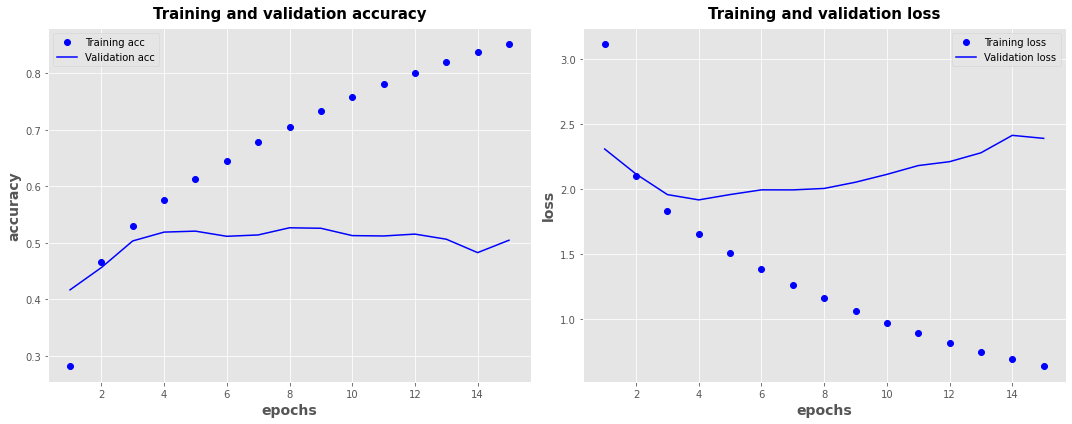

In [ ]:
plot_loss_accuracy(history2)

# 5. Conclusion

<a id="conclude"></a>


1. In this notebook, we explored some of text data visualization techniques to derive insights out of text data and make use of them into model training.

2. We built first model using simpleRNN and embedding layer of keras where we found maximum of 49% accuracy on test data and also noticed foregtting of model due to large sequences of inputs.

3. In our second model, we trained model using LSTMs and GRU for retaining information of longer sequences. we could 'optimize' model as it improved accuracy of training data significantly but it could not 'generalize well' enough on unseen data.